# **Computer Vision : Face Recognition**

In this project, the goal is to build a face identification model to recognize faces.

**Data Description**

This dataset contains of 10,770 images for 100 actor. All images are collected from 'Pinterest'.

**Objective**

In this problem, we use a pre-trained model trained on Face Recognition to recognize faces.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting the current working directory
import os; os.chdir('/content/drive/MyDrive/AIML/Computer Vision/Project')

### Import Packages

In [ ]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, sklearn, re, random
import matplotlib.gridspec as gridspec
from tqdm.notebook import tqdm
import tensorflow as tf
import cv2
%matplotlib inline

# Create features and labels
from tensorflow.keras.applications.mobilenet import preprocess_input

# Extract content from zipfile
from zipfile import ZipFile

# Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, Activation, BatchNormalization, SpatialDropout2D
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from sklearn.svm import SVC

# Encode, standardize and PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA

# Set random_state
random_state = 100

# Suppress warnings, if any
import warnings; warnings.filterwarnings('ignore')

# Print versions
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')
print(f'Tensorflow version: {tf.__version__}')
print(f'CV version: {cv2.__version__}')

Pandas version: 2.2.2
Numpy version: 1.26.4
Scikit-learn version: 1.6.1
Tensorflow version: 2.18.0
CV version: 4.11.0


##**PART I**

**In PART I, the goal is to build a face detection model which includes building a face detector to locate the position of a face in an image.**

**Task is to predict the boundaries(mask) around the face in a given image.**

###**Data Preprocessing and Visualization**

**Load 'image.npy' file**

In [ ]:
!ls

'Benedict Cumberbatch9.jpg'   PINS	       training_images-20211126T092819Z-001.zip
'Dwayne Johnson4.jpg'	      PINS.zip	       vgg_face_weights.h5
 face_metadata.csv	      Reference
 Images.npy		      temp_image.jpg


In [ ]:
import numpy as np
np.load = np.lib.npyio.load

# Load the data
data = np.load('/content/drive/MyDrive/AIML/Computer Vision/Project/Images.npy', allow_pickle=True)

**Check samples from the loaded file**

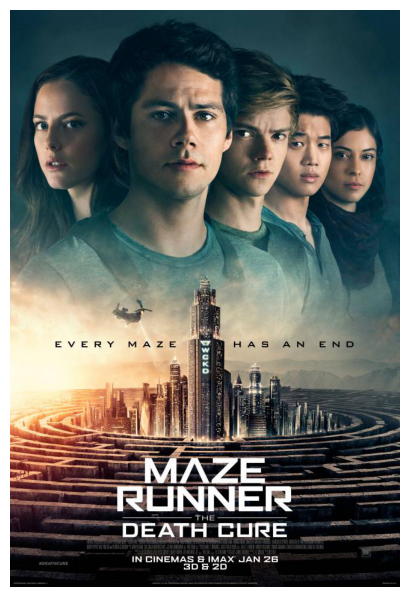

In [ ]:
fig = plt.figure(figsize = (15, 7.5))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[10][0])
plt.show()

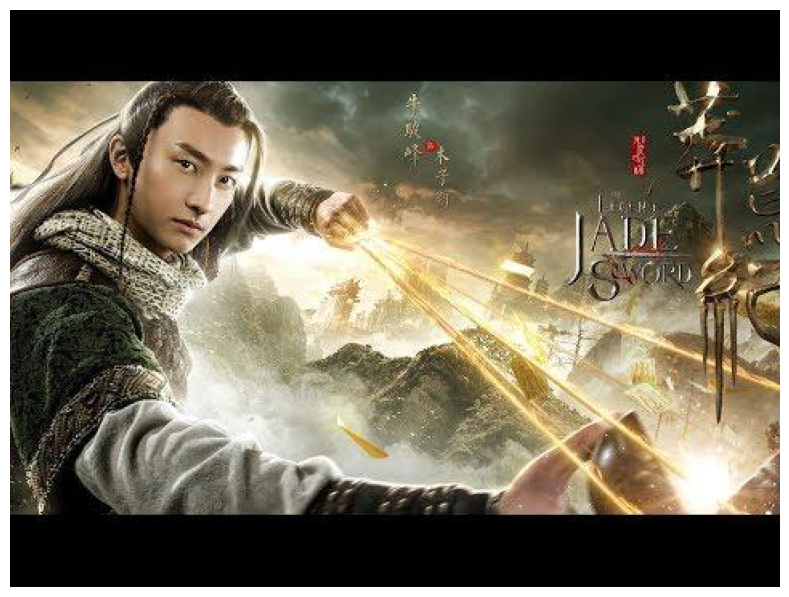

In [ ]:
fig = plt.figure(figsize = (15, 7.5))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
plt.imshow(data[20][0])
plt.show()

**Set image dimensions**
- Initialize image height, image width with value: 224
- Alpha: 1

In [ ]:
ALPHA = 1
IMAGE_SIZE = 224
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

**Create features and labels**
- Here feature is the image
- The label is the mask
- Images will be stored in 'X' array
- Masks will be stored in 'masks' array

In [ ]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize = (IMAGE_HEIGHT, IMAGE_WIDTH), interpolation = cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype = np.float32))
    for i in data[index][1]:
        x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
        x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
        y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

**Print the shape of X_train and mask array**

In [ ]:
X.shape

(393, 224, 224, 3)

In [ ]:
masks.shape

(393, 224, 224)

**Visualize the original and masked images**

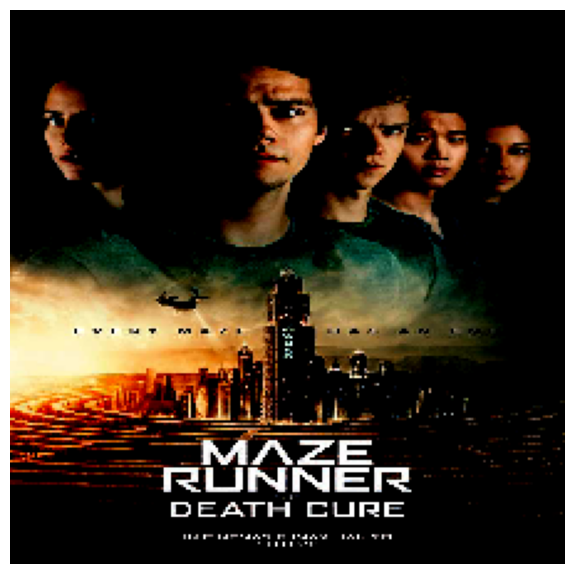

In [ ]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

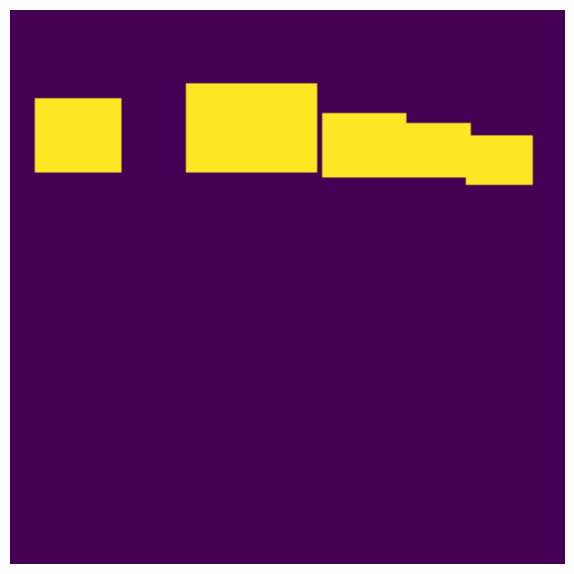

In [ ]:
n = 10
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

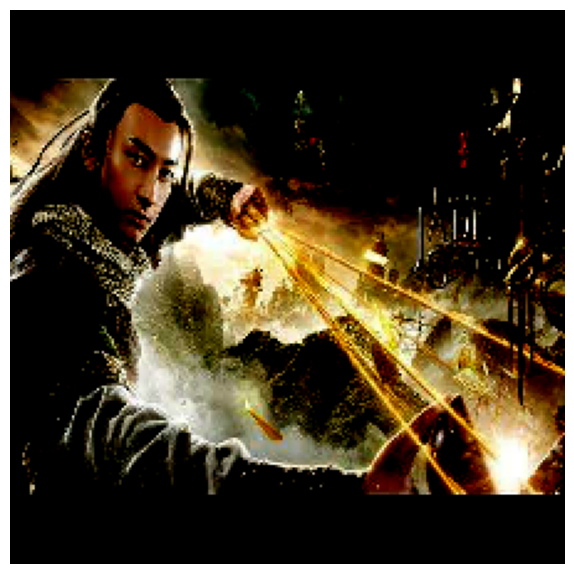

In [ ]:
n = 20
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(X[n])

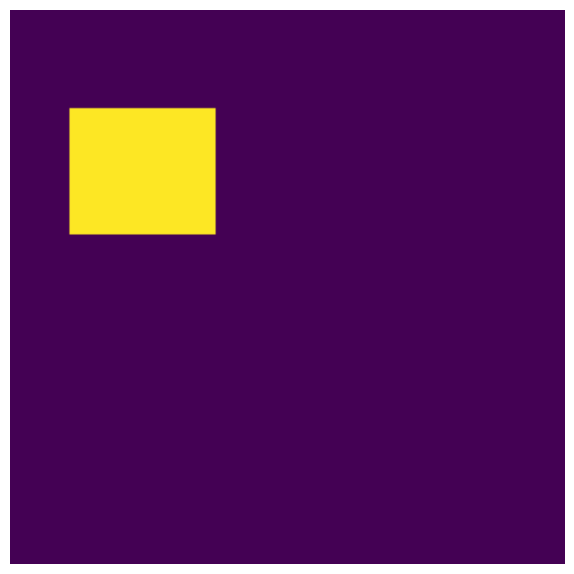

In [ ]:
n = 20
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
plt.axis('off')
_ = plt.imshow(masks[n])

**Splitting the dataset**

In [ ]:
# Split data into train and test sets
image_train, image_test, mask_train, mask_test = train_test_split(X, masks, test_size=0.2, random_state=42)

###**Model Building and Evaluation**

**Create the model**
- Use MobileNet as model with below parameter values
-- input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
-- include_top: False
-- alpha: 1.0
-- weights: 'imagenet'
- Use UNET architecture layers

In [ ]:
def conv_block_simple(prevlayer, filters, prefix, strides=(1, 1)):
    conv = Conv2D(filters, (3, 3), padding = 'same', kernel_initializer = 'he_normal', strides = strides, name = prefix + '_conv')(prevlayer)
    conv = BatchNormalization(name = prefix + 'BatchNormalization')(conv)
    conv = Activation('relu', name = prefix + 'ActivationLayer')(conv)
    return conv

def create_model(trainable = True):
    model = MobileNet(input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top = False, alpha = ALPHA, weights = 'imagenet')
    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer('conv_pw_13_relu').output
    block2 = model.get_layer('conv_pw_11_relu').output
    block3 = model.get_layer('conv_pw_5_relu').output
    block4 = model.get_layer('conv_pw_3_relu').output
    block5 = model.get_layer('conv_pw_1_relu').output

    up1 = Concatenate()([UpSampling2D()(block1), block2])
    conv6 = conv_block_simple(up1, 256, 'Conv_6_1')
    conv6 = conv_block_simple(conv6, 256, 'Conv_6_2')

    up2 = Concatenate()([UpSampling2D()(conv6), block3])
    conv7 = conv_block_simple(up2, 256, 'Conv_7_1')
    conv7 = conv_block_simple(conv7, 256, 'Conv_7_2')

    up3 = Concatenate()([UpSampling2D()(conv7), block4])
    conv8 = conv_block_simple(up3, 192, 'Conv_8_1')
    conv8 = conv_block_simple(conv8, 128, 'Conv_8_2')

    up4 = Concatenate()([UpSampling2D()(conv8), block5])
    conv9 = conv_block_simple(up4, 96, 'Conv_9_1')
    conv9 = conv_block_simple(conv9, 64, 'Conv_9_2')

    up5 = Concatenate()([UpSampling2D()(conv9), model.input])
    conv10 = conv_block_simple(up5, 48, 'Conv_10_1')
    conv10 = conv_block_simple(conv10, 32, 'Conv_10_2')
    conv10 = SpatialDropout2D(0.2)(conv10)

    x = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x)
    return Model(inputs = model.input, outputs = x)

**Create_model function**

In [ ]:
model = create_model(True)
model.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 32)   │            128 │ conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1                 │ (None, 112, 112, 32)   │            288 │ conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_bn              │ (None, 112, 112, 32)   │            128 │ conv_dw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_1_relu (ReLU)     │ (None, 112, 112, 32)   │              0 │ conv_dw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1 (Conv2D)        │ (None, 112, 112, 64)   │          2,048 │ conv_dw_1_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_bn              │ (None, 112, 112, 64)   │            256 │ conv_pw_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_1_relu (ReLU)     │ (None, 112, 112, 64)   │              0 │ conv_pw_1_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pad_2                │ (None, 113, 113, 64)   │              0 │ conv_pw_1_relu[0][0]   │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2                 │ (None, 56, 56, 64)     │            576 │ conv_pad_2[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_bn              │ (None, 56, 56, 64)     │            256 │ conv_dw_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_dw_2_relu (ReLU)     │ (None, 56, 56, 64)     │              0 │ conv_dw_2_bn[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2 (Conv2D)        │ (None, 56, 56, 128)    │          8,192 │ conv_dw_2_relu[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_pw_2_bn              │ (None, 56, 56, 128)    │            512 │ conv_pw_2[0][0]        │
│ (BatchNormalization) 

 Total params: 10,283,745 (39.23 MB)

 Trainable params: 10,258,689 (39.13 MB)

 Non-trainable params: 25,056 (97.88 KB)

**Fit the model**
- Fit the model using below parameters
-- epochs: we can try on 30 epochs
-- batch_size: 1
-- callbacks: checkpoint, reduce_lr, stop we did not use here because its become more computational expensive to system

**Before Fitting the model Installing CUDA libraries to make model computationly faster**

In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get update
!apt-get install cuda-11-8
!pip uninstall -y pycuda cupy-cuda11x numba

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-driver-550-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-550-server-550.144.03' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-doc' for glob 'nvidia*'
Note, selecting 'nvidia-imex' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-server-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-headless-390' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-gcc' for glob 'nvidia*'
Note, selecting 'nvidia-headless-418' for glob 'nvidia*'
Note, selecting 'nvidia-headless-430' for glob 'nvidia*'
Note, selecting 'nvidia-headless-435' for glob 'nvidia*'
Note, selecting 'nvidia-headless-440' for glob 'nvidia*'
Note, selecting 'nvidia-headless-450' for glob 'nvidia*'
Note, selecting 'nvidia-headless-455' for glob 'nv

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model1 = model.fit(image_train, mask_train, epochs=30, batch_size=1)

Epoch 1/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.0280 - loss: 0.3247
Epoch 2/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.0171 - loss: 0.2095
Epoch 3/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.0198 - loss: 0.1990
Epoch 4/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.0232 - loss: 0.1770
Epoch 5/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.0136 - loss: 0.1731
Epoch 6/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.0087 - loss: 0.1524
Epoch 7/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 21s 37ms/step - accuracy: 0.0095 - loss: 0.1600
Epoch 8/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.0063 - loss: 0.1403
Epoch 9/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.0044 - loss: 0.1087
Epoch 10/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 12s 37ms/step - accuracy: 0.0096 - loss: 0.1062
Epoch 11/30
314/314 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.0138 - loss: 0.0940
Epoch 12/30
314/314 ━━━━━━━━━━

**Define dice `IOU`, `coefficient function`, `Pixel Accuracy` to evaluate**

In [ ]:
from tensorflow.keras.metrics import MeanIoU, BinaryAccuracy

# Use the trained model for prediction
predicted_masks = model.predict(image_test)

# Calculate IoU
iou = MeanIoU(num_classes=2)
iou.update_state(mask_test, predicted_masks)
iou_score = iou.result().numpy()

# Calculate Dice coefficient
dice_score = 2 * np.sum(predicted_masks * mask_test) / (np.sum(predicted_masks) + np.sum(mask_test))

# Calculate pixel accuracy
accuracy = BinaryAccuracy()
accuracy.update_state(mask_test, predicted_masks)
accuracy_score = accuracy.result().numpy()

print(f"IoU: {iou_score:.4f}")
print(f"Dice Coefficient: {dice_score:.4f}")
print(f"Pixel Accuracy: {accuracy_score:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step
IoU: 0.5983
Dice Coefficient: 0.5923
Pixel Accuracy: 0.8698


**Define the function for visualize prediction of model**

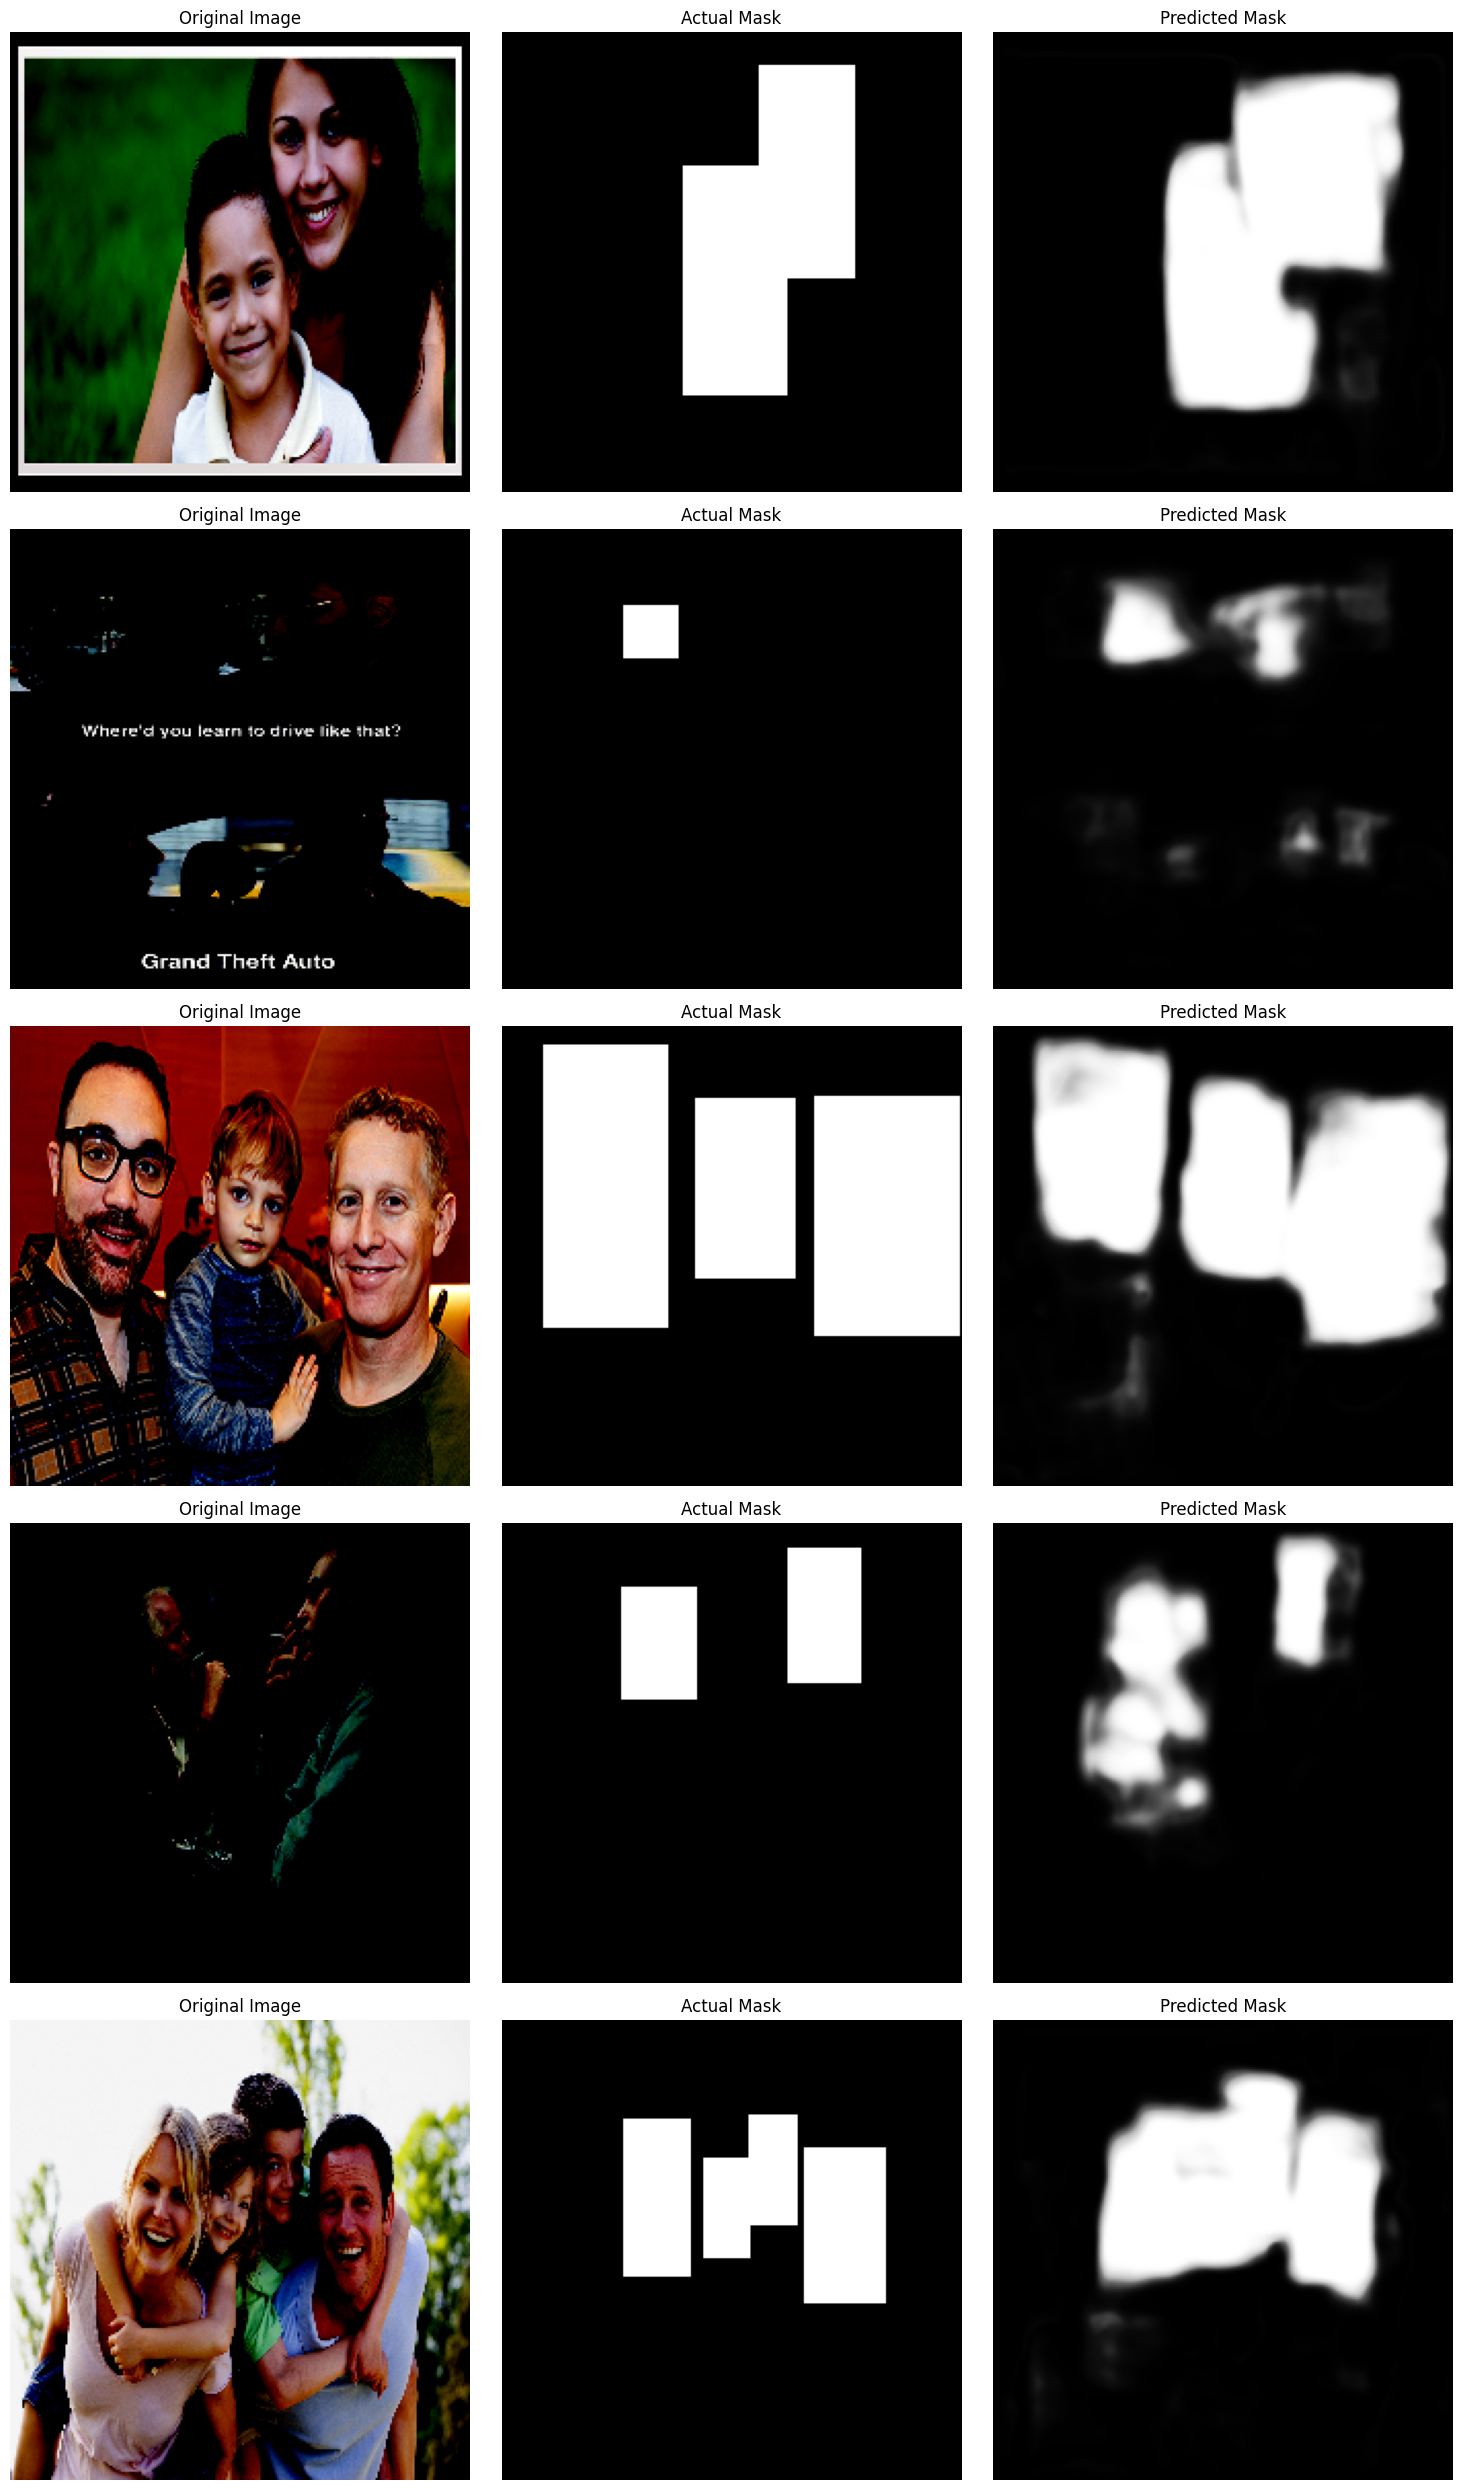

In [ ]:
# Visualize predictions
def visualize_predictions(num_samples=5):
  """Visualizes predicted masks alongside actual masks and original images."""

  fig, axes = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))

  for i in range(num_samples):
    index = np.random.randint(0, len(image_test))

    # Original Image
    axes[i, 0].imshow(image_test[index])
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    # Actual Mask
    axes[i, 1].imshow(mask_test[index], cmap='gray')
    axes[i, 1].set_title("Actual Mask")
    axes[i, 1].axis("off")

    # Predicted Mask
    axes[i, 2].imshow(predicted_masks[index], cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis("off")

  plt.tight_layout()
  plt.show()

visualize_predictions()

**Insights**:

- **Visual Inspection**: By visually comparing the actual masks with the predicted masks, we can gain a qualitative understanding of the model's performance.

- **Accurate Predictions**: The model should ideally generate masks that closely align with the ground truth masks, indicating that it is correctly identifying the face regions in the images.

- **False Positives**: The model might predict mask regions where there are no faces, leading to false positives. These errors can occur due to noise in the images or the model's inability to distinguish between face-like features and other objects.

- **False Negatives**: The model might miss some face regions, leading to false negatives. These errors can occur when the faces are occluded, poorly lit, or have unusual poses.

- **Quantitative Metrics**: The calculated metrics like IoU, Dice coefficient, and Pixel Accuracy provide quantitative insights into the model's performance:

- **IoU and Dice Coefficient**: Higher values for these metrics (closer to 1) indicate better overlap between the predicted and actual masks, suggesting that the model is accurately segmenting the face regions.

- **Pixel Accuracy**: This metric reflects the percentage of pixels correctly classified by the model. A high pixel accuracy suggests that the model is making accurate predictions at the pixel level.


**Conclusion**:

Based on the insights gained from the visualizations and metrics, we can draw conclusions about the model's performance.

- **Overall Performance**: The model achieved an IoU score of **0.5983**, a Dice coefficient of **0.5923**, and a pixel accuracy of **0.8698**. These values suggest that the model performs well in predicting face masks.

- **Strengths and Weaknesses**: The model effectively identifies face regions in most cases, as evident from the visual comparison and high accuracy metrics. However, it might struggle with occluded faces or face-like features in the background.

- **Areas for Improvement**: To further improve the model's performance, we can allow,

- **Data Augmentation**: Introduce more variations in the training data, such as rotations, flips, and brightness adjustments, to make the model more robust to different face orientations and lighting conditions.

- **Model Architecture:** Explore alternative architectures or fine-tune hyperparameters to optimize the model's ability to extract relevant features for accurate mask prediction.

- **Error Analysis:** Carefully analyze the cases where the model makes errors to understand the underlying reasons for the mistakes. This analysis can guide further improvements in data preprocessing, model training, or post-processing techniques.

###**Predicting Face Masks from Images**

In [ ]:
!ls

'Benedict Cumberbatch9.jpg'   PINS	       training_images-20211126T092819Z-001.zip
'Dwayne Johnson4.jpg'	      PINS.zip	       vgg_face_weights.h5
 face_metadata.csv	      Reference
 Images.npy		      temp_image.jpg


**Import necessary libraries**

In [ ]:
!pip install opencv-python==4.7.0.72
!pip install face-recognition==1.3.0

import os
import face_recognition
import cv2
import zipfile
import pandas as pd
import matplotlib.pyplot as plt

  Using cached face_recognition-1.3.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached face_recognition_models-0.3.0.tar.gz (100.1 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=700d30c992a3fabe222eff470aafd42a90faf0be7cef24dd8fa72f07252ef0bd
  Stored in directory: /root/.cache/pip/wheels/04/52/ec/9355da79c29f160b038a20c784db2803c2f9fa2c8a462c176a
Successfully built face-recognition-models


**Define a function to extract face metadata:**

In [ ]:
def extract_face_metadata(image_path):
    """
    Detects faces in an image, extracts metadata, and returns it as a list of dictionaries.
    """
    image = face_recognition.load_image_file(image_path)
    face_locations = face_recognition.face_locations(image)
    face_landmarks = face_recognition.face_landmarks(image, face_locations)

    metadata = []
    for (top, right, bottom, left), landmarks in zip(face_locations, face_landmarks):
        face_metadata = {
            'image_path': image_path,
            'top': top,
            'right': right,
            'bottom': bottom,
            'left': left,
            'landmarks': landmarks
        }
        metadata.append(face_metadata)

    return metadata

**Iterate through images and extract metadata:**

In [ ]:
folder_path = '/content/drive/MyDrive/AIML/Computer Vision/Project/training_images-20211126T092819Z-001.zip'
all_metadata = []

# Open the zip file
with zipfile.ZipFile(folder_path, 'r') as zip_ref:
    # Iterate through files within the zip file
    for filename in zip_ref.namelist():
        if filename.endswith(('.jpg', '.jpeg', '.png')):
            # Extract the image to a temporary file
            with zip_ref.open(filename) as image_file:
                image = image_file.read()
                with open("temp_image.jpg", "wb") as temp_file:
                    temp_file.write(image)

            # Process the image (e.g., extract metadata)
            metadata = extract_face_metadata("temp_image.jpg")
            all_metadata.extend(metadata)

            # Optionally remove the temporary file
            os.remove("temp_image.jpg")

**Create and save the DataFrame**

In [ ]:
df = pd.DataFrame(all_metadata)
df.to_csv('face_metadata.csv', index=False)  # Save to a CSV file

**Face detection**

In [ ]:
def visualize_face_detection(image_path, metadata):
    """
    Draws bounding boxes around detected faces in an image, displays it,
    and returns the prediction.
    """
    try:
        # Assuming 'image_path' is a relative path within the zip file
        with zipfile.ZipFile(folder_path, 'r') as zip_ref:
          # Get the actual filename from the zip archive
          for filename in zip_ref.namelist():
              if filename.endswith(image_path):
                image_path_in_zip = filename
                break

          with zip_ref.open(image_path_in_zip) as image_file: # Open the file within the zip
                image = image_file.read()
                image = cv2.imdecode(np.frombuffer(image, np.uint8), cv2.IMREAD_COLOR)

        # Check if the image was loaded successfully
        if image is None:
            print(f"Error: Could not load image from {image_path}")
            return None, None  # Return None for both image and prediction

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB for display

        for face_data in metadata:
            top, right, bottom, left = face_data['top'], face_data['right'], face_data['bottom'], face_data['left']
            cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)  # Draw green bounding box

        # --- Prediction part ---
        # Normalizing pixel values
        image_for_prediction = (image / 255.).astype(np.float32)  # Create a copy for prediction
        # Resize
        image_for_prediction = cv2.resize(image_for_prediction, (224, 224))

        # Obtain embedding vector for sample image
        embedding = vgg_face_descriptor.predict(np.expand_dims(image_for_prediction, axis=0))[0]
        # Scaled the vector and reshape
        embedding_scaled = sc.transform(embedding.reshape(1, -1))
        # Predict
        sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
        # Transform back
        pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()

        plt.figure(figsize=(8, 6))
        plt.imshow(image)
        plt.title(f'Face Detection - Predicted: {pred_name}')
        plt.axis('off')
        plt.show()

        return image, pred_name  # Return the image and prediction

    except Exception as e:
        print(f"Error: {e}")
        return None, None

**Insights from Predicting Face Masks:**

- **Automation:** The code automates the process of detecting faces and extracting metadata from multiple images, saving time and effort.

- **Data Organization:** The metadata is organized into a structured DataFrame, making it easy to analyze and use for further tasks like model training or visualization.

- **Feature Extraction:** The extracted metadata includes bounding box coordinates and facial landmarks, which can be used as features for face recognition or other computer vision applications.

- **Data Persistence:** Saving the DataFrame to a CSV file allows you to store the extracted metadata for later use without re-running the extraction process.

##**PART II**

**In this PART II, the goal is to build a face identification model to recognize faces.**

**This dataset contains 10,770 images for 100 people. All images are taken from 'Pinterest'**

**In this problem, we use a pre-trained model trained on Face Recognition to recognize similar faces. Here, we are particularly interested in recognizing whether two given faces are of the same person or not.**

**Task is to recognize a faces**

###**Data Preprocessing and Visualization**

In [ ]:
!ls

'Benedict Cumberbatch9.jpg'   PINS	       training_images-20211126T092819Z-001.zip
'Dwayne Johnson4.jpg'	      PINS.zip	       vgg_face_weights.h5
 face_metadata.csv	      Reference
 Images.npy		      temp_image.jpg


**Define paths**

In [ ]:
with ZipFile('/content/drive/MyDrive/AIML/Computer Vision/Project/PINS.zip', 'r') as zip:
  zip.extractall()

**Extract images from the zip file**

In [ ]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file)

def load_metadata(path):
    metadata = []
    exts = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
                exts.append(ext)
    return np.array(metadata), exts

metadata, exts = load_metadata('PINS')
labels = np.array([meta.name for meta in metadata])

In [ ]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

###**Visualizing Similar Images**

**Read images and extract labels**

In [ ]:
n = np.random.randint(1, len(metadata))
img_path = metadata[n].image_path()
img = load_image(img_path)

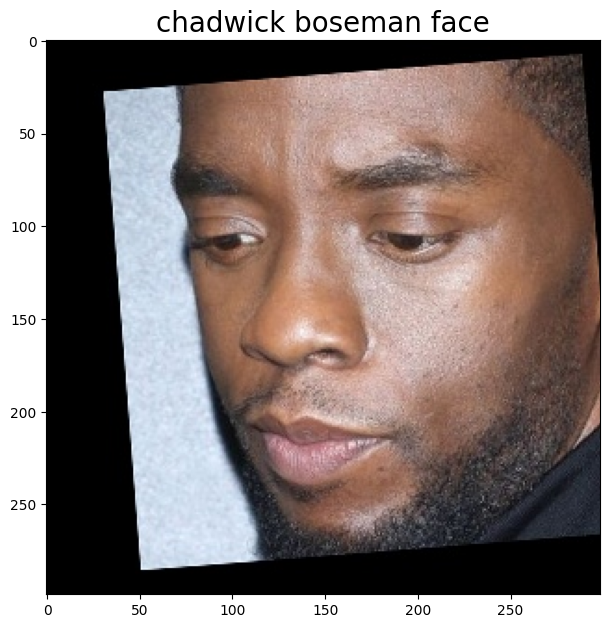

In [ ]:
fig = plt.figure(figsize = (15, 7.2))
ax = fig.add_subplot(1, 1, 1)
title = labels[n].split('_')[1]
ax.set_title(title, fontsize = 20)
_ = plt.imshow(img)

**VGG Face model**

In [ ]:
def vgg_face():
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape = (224, 224, 3)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides = (2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides =(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(Convolution2D(4096, (7, 7), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

**Load the model**
- Load the model defined above
- Then load the given weight file named "vgg_face_weights.h5"

In [ ]:
vgg_model = vgg_face()
vgg_model.load_weights('vgg_face_weights.h5') # Load weights into the vgg_model, not the 'model' variable
print(vgg_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ zero_padding2d (ZeroPadding2D)       │ (None, 226, 226, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 226, 226, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_2 (ZeroPadding2D)     │ (None, 114, 114, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_3 (ZeroPadding2D)     │ (None, 114, 114, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_4 (ZeroPadding2D)     │ (None, 58, 58, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_5 (ZeroPadding2D)     │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_6 (ZeroPadding2D)     │ (None, 58, 58, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_7 (ZeroPadding2D)     │ (None, 30, 30, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_8 (ZeroPadding2D)     │ (None, 30, 30, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 145,002,878 (553.14 MB)

 Trainable params: 145,002,878 (553.14 MB)

 Non-trainable params: 0 (0.00 B)

None


**Get vgg_face_descriptor**

In [ ]:
vgg_face_descriptor = Model(inputs = vgg_model.layers[0].input, outputs = vgg_model.layers[-2].output)


**Generate embeddings for each image in the dataset**
- Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model.

In [ ]:
# Get embedding vector for first image in the metadata using the pre-trained model

img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0, 1]
img = (img / 255.).astype(np.float32)

img = cv2.resize(img, dsize = (224, 224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(img, axis = 0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
(2622,)


**Generate embeddings for all images**
- Below code to iterate through metadata and create embeddings for each image using vgg_face_descriptor.predict() and store in a list with name embeddings

**We are checking our GPU available, If GPU's not available in our system then we install cuda nvidia GPU to make computational faster model**

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get update
!apt-get install cuda-11-8
!pip install -U nvidia-cudnn-cu11==8.9.0.131

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-driver-550-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-550-server-550.144.03' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-doc' for glob 'nvidia*'
Note, selecting 'nvidia-imex' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-firmware-535-server-535.154.05' for glob 'nvidia*'
Note, selecting 'nvidia-headless-390' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-gcc' for glob 'nvidia*'
Note, selecting 'nvidia-headless-418' for glob 'nvidia*'
Note, selecting 'nvidia-headless-430' for glob 'nvidia*'
Note, selecting 'nvidia-headless-435' for glob 'nvidia*'
Note, selecting 'nvidia-headless-440' for glob 'nvidia*'
Note, selecting 'nvidia-headless-450' for glob 'nvidia*'
Note, selecting 'nvidia-headless-455' for glob 'nv

In [ ]:
batch_size = 32  # Adjust according to your GPU memory
num_batches = int(np.ceil(len(metadata) / batch_size))

embeddings = []
for i in tqdm(range(num_batches)):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(metadata))

    # Load and resize images in the batch
    batch_images = []
    for meta in metadata[start_idx:end_idx]:
        img = load_image(str(meta))
        img = cv2.resize(img, (224, 224))  # Resize to the expected input shape
        img = (img / 255.).astype(np.float32)  # Normalize
        batch_images.append(img)

    batch_embeddings = vgg_face_descriptor.predict(np.array(batch_images))
    embeddings.extend(batch_embeddings)

embeddings = np.array(embeddings)

  0%|          | 0/337 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 23s 23s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 21s 21s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step
1/1 ━━━━━━━━

**Function to calculate distance between given 2 pairs of images**
- Consider distance metric as "Squared L2 distance"
- Squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2

In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

**Plot images and get distance between the pairs given below**
- 2, 3 and 2, 180
- 30, 31 and 30, 100
- 70, 72 and 70, 115

In [ ]:
def show_pair(idx1, idx2):
    plt.figure(figsize = (8, 3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()))

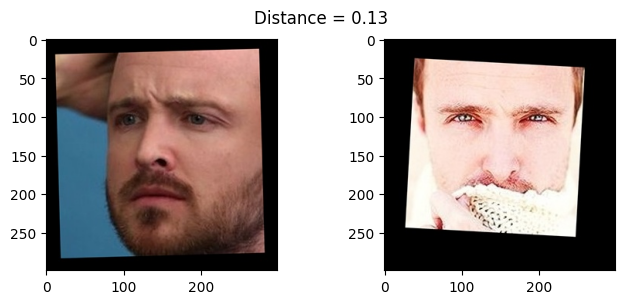

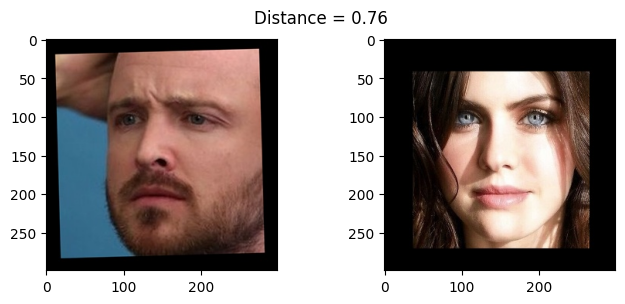

In [ ]:
show_pair(2, 3)
show_pair(2, 180)

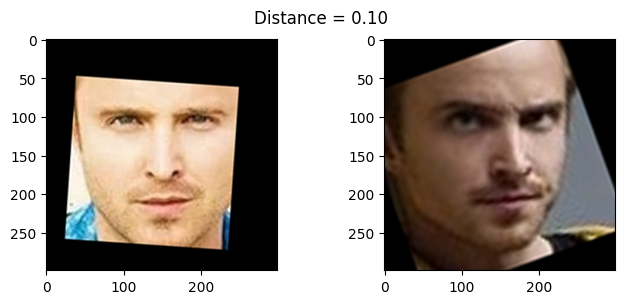

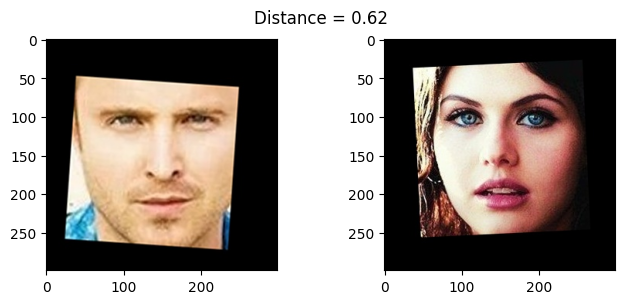

In [ ]:
show_pair(30, 31)
show_pair(30, 100)

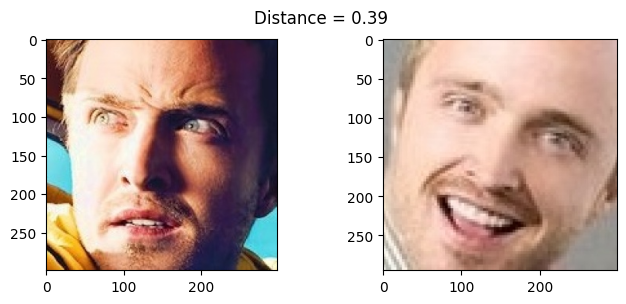

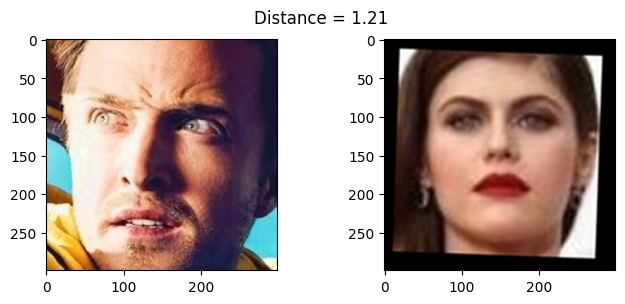

In [ ]:
show_pair(70, 72)
show_pair(70, 115)

**Create train and test sets**
- Create X_train, X_test and y_train, y_test
- Use train_idx to seperate out training features and labels
- Use test_idx to seperate out testing features and labels

In [ ]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# Features
X_train = np.array(embeddings)[train_idx]
X_test = np.array(embeddings)[test_idx]

# Labels
y_train = np.array([meta.name for meta in metadata[train_idx]])
y_test = np.array([meta.name for meta in metadata[test_idx]])

display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(9573, 2622)

(1197, 2622)

(9573,)

(1197,)

**Encode the Labels**
- Encode the labels
- Use LabelEncoder

In [ ]:
# Encode labels
en = LabelEncoder()
y_train = en.fit_transform(y_train)
y_test = en.transform(y_test)

**Standardize the feature values**
- Scale the features using StandardScaler

In [ ]:
# Standarize features
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

###**Model Building and Inference**

**Reduce dimensions using PCA**
- Reduce feature dimensions using Principal Component Analysis

In [ ]:
# Covariance matrix
cov_matrix = np.cov(X_train_sc.T)

# Eigen values and vector
eig_vals, eig_vecs = np.linalg.eig(cov_matrix)

# Cumulative variance explained
tot = sum(eig_vals)
var_exp = [(i /tot) * 100 for i in sorted(eig_vals, reverse = True)]
cum_var_exp = np.cumsum(var_exp)

print('Cumulative Variance Explained', cum_var_exp)

Cumulative Variance Explained [ 13.60590508  18.999629    22.97008671 ...  99.99999983  99.99999999
 100.        ]


In [ ]:
# Get index where cumulative variance explained is > threshold
thres = 95
res = list(filter(lambda i: i > thres, cum_var_exp))[0]
index = (cum_var_exp.tolist().index(res))
print(f'Index of element just greater than {thres}: {str(index)}')

Index of element just greater than 95: 347


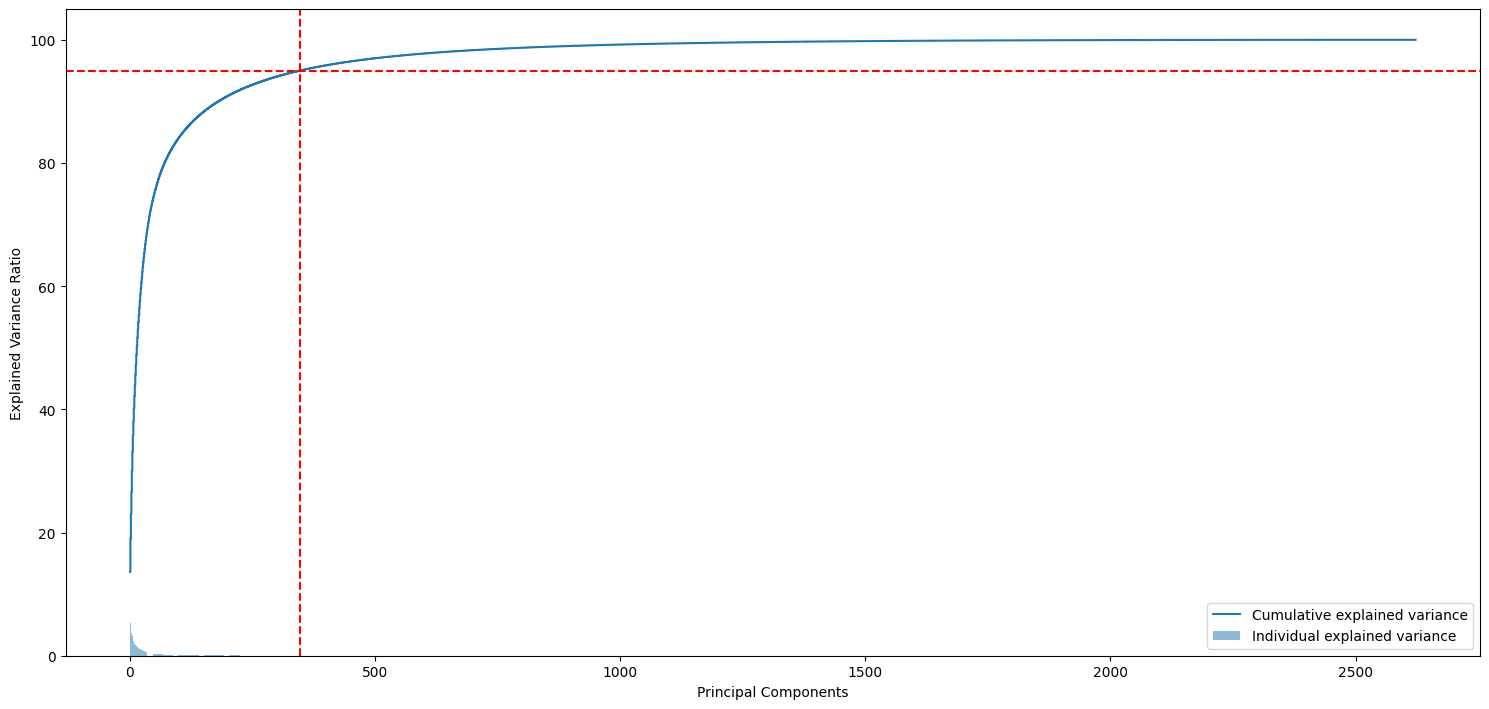

In [ ]:
# Ploting
plt.figure(figsize = (15 , 7.2))
plt.bar(range(1, eig_vals.size + 1), var_exp, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, eig_vals.size + 1), cum_var_exp, where = 'mid', label = 'Cumulative explained variance')
plt.axhline(y = thres, color = 'r', linestyle = '--')
plt.axvline(x = index, color = 'r', linestyle = '--')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

In [ ]:
# Reducing the dimensions
pca = PCA(n_components = index, random_state = random_state, svd_solver = 'full', whiten = True)
pca.fit(X_train_sc)
X_train_pca = pca.transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
display(X_train_pca.shape, X_test_pca.shape)

(9573, 347)

(1197, 347)

**Build a Classifier**
- Use SVM Classifier to predict the person in the given image
- Fit the classifier and print the score

In [ ]:
svc_pca = SVC(C = 1, gamma = 0.001, kernel = 'rbf', class_weight = 'balanced', random_state = random_state)
svc_pca.fit(X_train_pca, y_train)
print('SVC accuracy for train set: {0:.3f}'.format(svc_pca.score(X_train_pca, y_train)))

SVC accuracy for train set: 0.994


In [ ]:
#Predict
y_pred = svc_pca.predict(X_test_pca)

# Accuracy Score
print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.9682539682539683


In [ ]:
names = [name.split('_')[1].title().strip() for name in labels]

# Classification Report
print('Classification Report: \n{}'.format(classification_report(y_test, y_pred, target_names = np.unique(names))))

Classification Report: 
                          precision    recall  f1-score   support

              Aaron Paul       1.00      1.00      1.00        10
      Alexandra Daddario       0.83      1.00      0.91        10
            Alvaro Morte       1.00      0.93      0.96        14
Alycia Debnam Carey Face       1.00      1.00      1.00        12
             Amanda Crew       1.00      0.86      0.92         7
          Amaury Nolasco       1.00      1.00      1.00         9
        Amber Heard Face       1.00      1.00      1.00         7
               Anna Gunn       0.93      1.00      0.97        14
           Anne Hathaway       1.00      0.93      0.96        14
     Barbara Palvin Face       1.00      0.89      0.94         9
      Bellamy Blake Face       0.87      0.93      0.90        14
    Benedict Cumberbatch       1.00      0.92      0.96        12
            Betsy Brandt       1.00      1.00      1.00        10
              Bill Gates       0.90      0.90      

**Test results**
- Take 20th image from test set and plot the image
- Report to which person the image belongs to

In [ ]:
def sample_img_plot(sample_idx):
  # Load image for sample_idx from test data
  sample_img = load_image(metadata[test_idx][sample_idx].image_path())
  # Get actual name
  actual_name = metadata[test_idx][sample_idx].name.split('_')[-1].title().strip()
  # Normalizing pixel values
  sample_img = (sample_img/255.).astype(np.float32)
  # Resize
  sample_img = cv2.resize(sample_img, (224, 224))

  # Obtain embedding vector for sample image
  embedding = vgg_face_descriptor.predict(np.expand_dims(sample_img, axis = 0))[0]
  # Scaled the vector and reshape
  embedding_scaled = sc.transform(embedding.reshape(1, -1))
  # Predict
  sample_pred = svc_pca.predict(pca.transform(embedding_scaled))
  # Transform back
  pred_name = en.inverse_transform(sample_pred)[0].split('_')[-1].title().strip()
  return sample_img, actual_name, pred_name

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 620ms/step


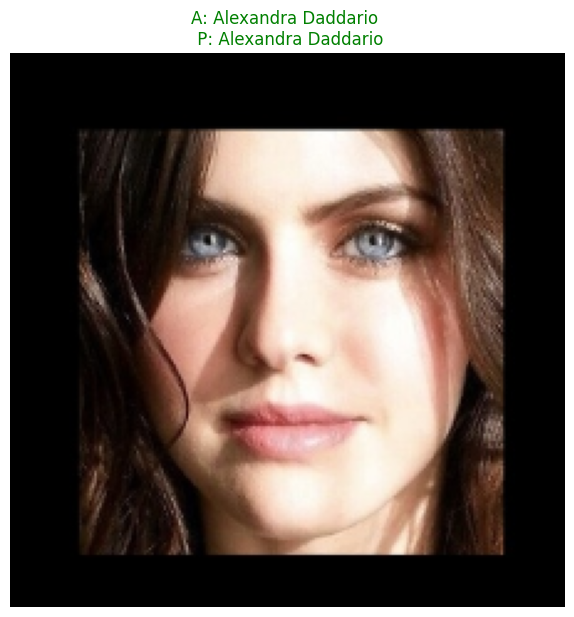

In [ ]:
# Plot for 20th image in test data
sample_img, actual_name, pred_name = sample_img_plot(20)
fig = plt.figure(figsize = (15, 7.2))
plt.axis('off')
plt.imshow(sample_img)
plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 618ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 989ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 972ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 629ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 602ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 

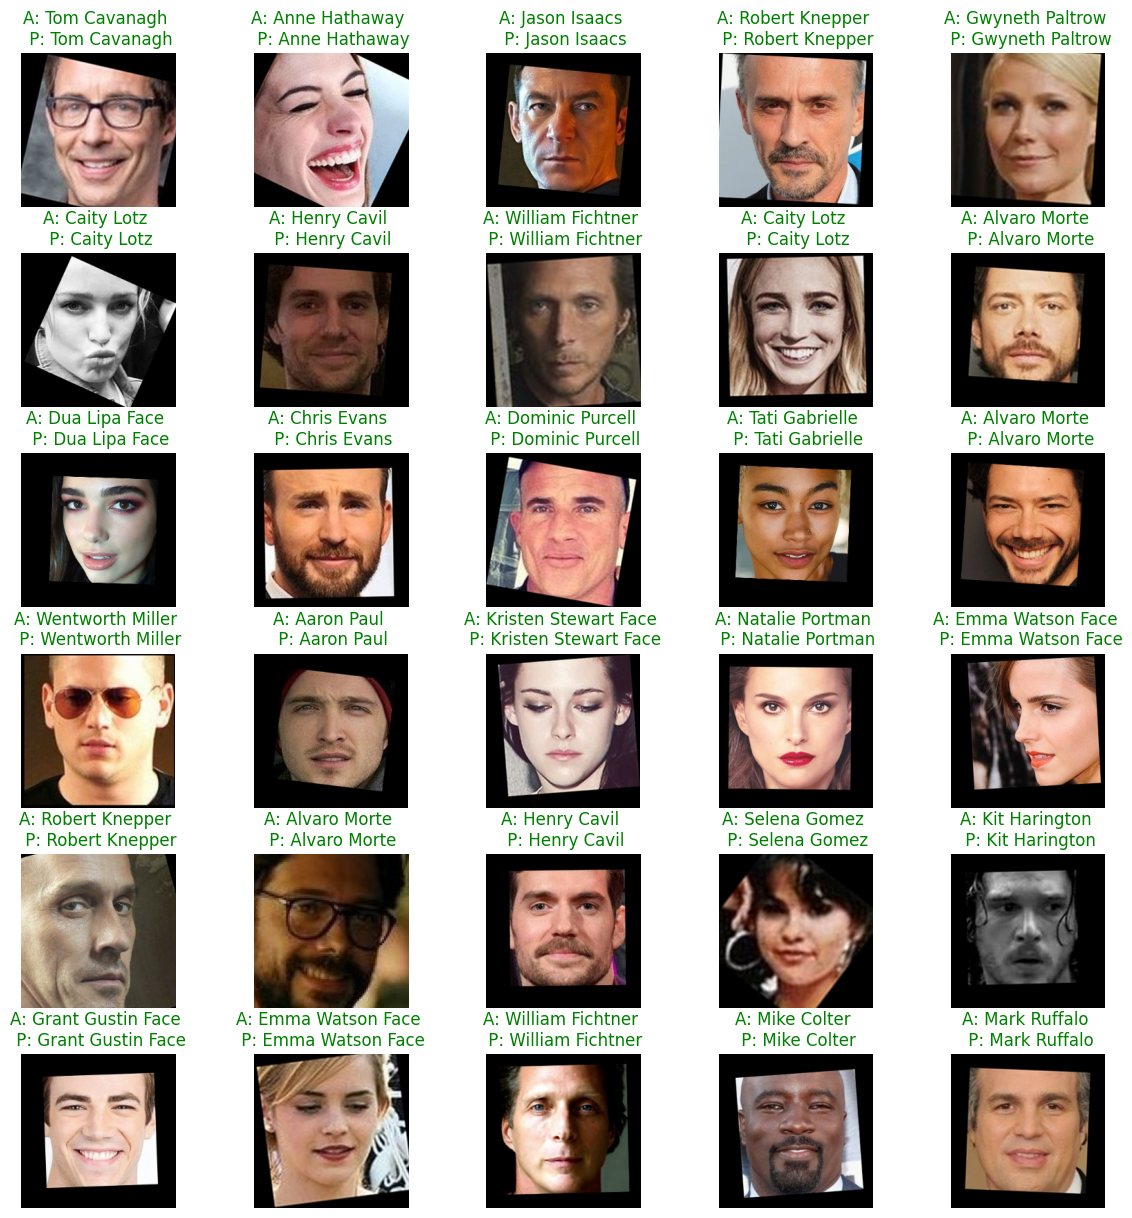

In [ ]:
# Random 30 sample images from test data
plt.figure(figsize = (15, 15))

# Changed GridSpec to accommodate 30 plots (6 rows, 5 columns)
gs1 = gridspec.GridSpec(6, 5)
gs1.update(wspace = 0, hspace = 0.3)

for i in range(30):
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')

    sample_img, actual_name, pred_name = sample_img_plot(random.randint(1, 1197))

    plt.axis('off')
    plt.imshow(sample_img)

    plt.title(f"A: {actual_name} \n P: {pred_name}", color = 'green' if actual_name == pred_name else 'red')
plt.show()

###**Actionable Insights & Recommendations**

**Actionable Insights:**

- **High Accuracy, Strong Potential:**
The model's high accuracy on the test set suggests that face recognition technology can be a valuable tool for businesses. It can be deployed for various applications like security systems, personalized customer experiences, and employee authentication.

- **PCA's Efficiency:**
Utilizing PCA to reduce dimensionality without sacrificing much accuracy highlights the importance of efficient data processing. This can lead to cost savings and faster response times in real-world applications.

- **Distance Metric Matters:**
The choice of distance metric significantly impacts accuracy. Businesses need to carefully consider the appropriate metric for their specific use case, as it directly influences the model's ability to distinguish between faces.

- **Fine-Tuning for Optimal Performance:**
The performance of face recognition systems can be further enhanced through hyperparameter optimization and model selection. Investing in fine-tuning the model can lead to noticeable improvements in accuracy.

- **Understanding Limitations:**
While face recognition technology is powerful, it's crucial to acknowledge its limitations. Certain conditions, such as variations in lighting or facial expressions, can affect accuracy. Businesses should consider strategies to address these challenges.

**Recommendations:**

- **Develop Targeted Solutions:** Businesses should focus on developing face recognition solutions tailored to their specific needs and industry. Consider integrating face recognition into existing systems for security, customer service, or marketing purposes.

- **Data Augmentation for Robustness:** To improve the model's performance in real-world scenarios, implement data augmentation techniques. This involves introducing variations in lighting, pose, and facial expressions during training to enhance the model's ability to handle diverse conditions.

- **Explore Advanced Models:** Explore more advanced deep learning architectures like FaceNet or ArcFace, which have demonstrated even higher accuracy in face recognition tasks. These models might be more suitable for demanding business applications.

- **Hyperparameter Optimization:** Utilize techniques like GridSearchCV or RandomizedSearchCV to systematically optimize the model's hyperparameters. This process can significantly improve the model's accuracy and generalization ability.
Error Analysis for Targeted Improvement: Conduct thorough error analysis to understand the specific situations where the model makes mistakes. This analysis will guide further improvements and help address the model's weaknesses.

- **Address Ethical and Privacy Concerns:** Businesses should be mindful of the ethical implications and privacy concerns surrounding face recognition technology. Implement clear policies and safeguards to protect user data and ensure responsible deployment.

- **User Experience Considerations:** Focus on creating a seamless and user-friendly experience when integrating face recognition. Ensure that the process is quick, accurate, and minimizes any inconvenience for users.